<!-- <div style="text-align: center;">
    <h1 style="color:rgb(94, 240, 94);">👗 AI-Powered Clothing Try-On System</h1>
    <p>Goal: Allow users to upload their photo and try on different clothes virtually. This can be tops, dresses, shirts, etc.</p>
</div> -->

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU, Concatenate, Activation, Dropout

BASE_DIR = r"C:\Users\abdul\PycharmProjects\DL_projects\AI_Powered_Clothing_Try_On\data\train"

IMAGE_DIR = os.path.join(BASE_DIR, "image")
CLOTH_DIR = os.path.join(BASE_DIR, "cloth")
CLOTH_MASK_DIR = os.path.join(BASE_DIR, "cloth-mask")
PARSE_DIR = os.path.join(BASE_DIR, "image-parse")
AGNOSTIC_DIR = os.path.join(BASE_DIR, "agnostic")


In [8]:
import tensorflow as tf

def load_and_preprocess_image(image_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


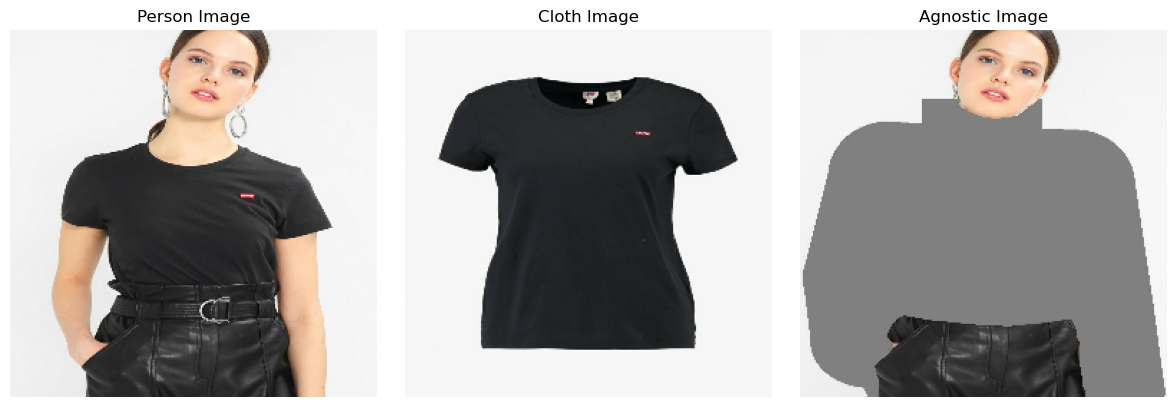

In [9]:
import matplotlib.pyplot as plt

# Sample filenames (pick any from the folder)
sample_id = "00001_00"  # You can change this to another ID

# Paths
person_image_path = os.path.join(IMAGE_DIR, f"{sample_id}.jpg")
cloth_image_path = os.path.join(CLOTH_DIR, f"{sample_id}.jpg")
agnostic_image_path = os.path.join(AGNOSTIC_DIR, f"{sample_id}.jpg")

# Load images
person_img = load_and_preprocess_image(person_image_path)
cloth_img = load_and_preprocess_image(cloth_image_path)
agnostic_img = load_and_preprocess_image(agnostic_image_path)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(person_img)
plt.title("Person Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cloth_img)
plt.title("Cloth Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(agnostic_img)
plt.title("Agnostic Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
def prepare_training_data(img_id):
    person_image_path= os.path.join(IMAGE_DIR, f"{img_id}.jpg") #target image
    cloth_image_path = os.path.join(CLOTH_DIR,f"{img_id}.jpg") #source image
    agnostic_image_path = os.path.join(AGNOSTIC_DIR,f"{img_id}.jpg") #agnostic image
    
    person_img = load_and_preprocess_image(person_image_path)
    cloth_img = load_and_preprocess_image(cloth_image_path)
    agnostic_img = load_and_preprocess_image(agnostic_image_path)

    input_tensor = np.concatenate([cloth_img,agnostic_img], axis=-1) #concatenate the two images along the last axis
    return input_tensor, person_img #return the input tensor and the target image

In [11]:
input_tensor, target = prepare_training_data("00001_00")
print("Input shape:", input_tensor.shape)   # (256, 256, 6)
print("Target shape:", target.shape)        # (256, 256, 3)


Input shape: (256, 256, 6)
Target shape: (256, 256, 3)


In [12]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    # Downsample with stride=2
    g = Conv2D(filters=n_filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g


def define_decoder_block(layer_in, skip_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g


In [13]:
def define_generator(image_shape=(256, 256, 6)):
    init = RandomNormal(stddev=0.02)
    in_image = tf.keras.layers.Input(shape=image_shape)

    # Encoder
    e1 = define_encoder_block(in_image, 64, batchnorm=False)  # 128x128
    e2 = define_encoder_block(e1, 128)                        # 64x64
    e3 = define_encoder_block(e2, 256)                        # 32x32
    e4 = define_encoder_block(e3, 512)                        # 16x16
    e5 = define_encoder_block(e4, 512)                        # 8x8
    e6 = define_encoder_block(e5, 512)                        # 4x4

    # Bottleneck
    b = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(e6)  # 2x2
    b = Activation('relu')(b)

    # Decoder
    d1 = define_decoder_block(b, e6, 512)   # 4x4
    d2 = define_decoder_block(d1, e5, 512)  # 8x8
    d3 = define_decoder_block(d2, e4, 512)  # 16x16
    d4 = define_decoder_block(d3, e3, 256)  # 32x32
    d5 = define_decoder_block(d4, e2, 128)  # 64x64
    d6 = define_decoder_block(d5, e1, 64)   # 128x128

    # Output layer (up to 256x256)
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d6)
    output_image = Activation('tanh')(g)

    model = Model(in_image, output_image)
    return model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  6208        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


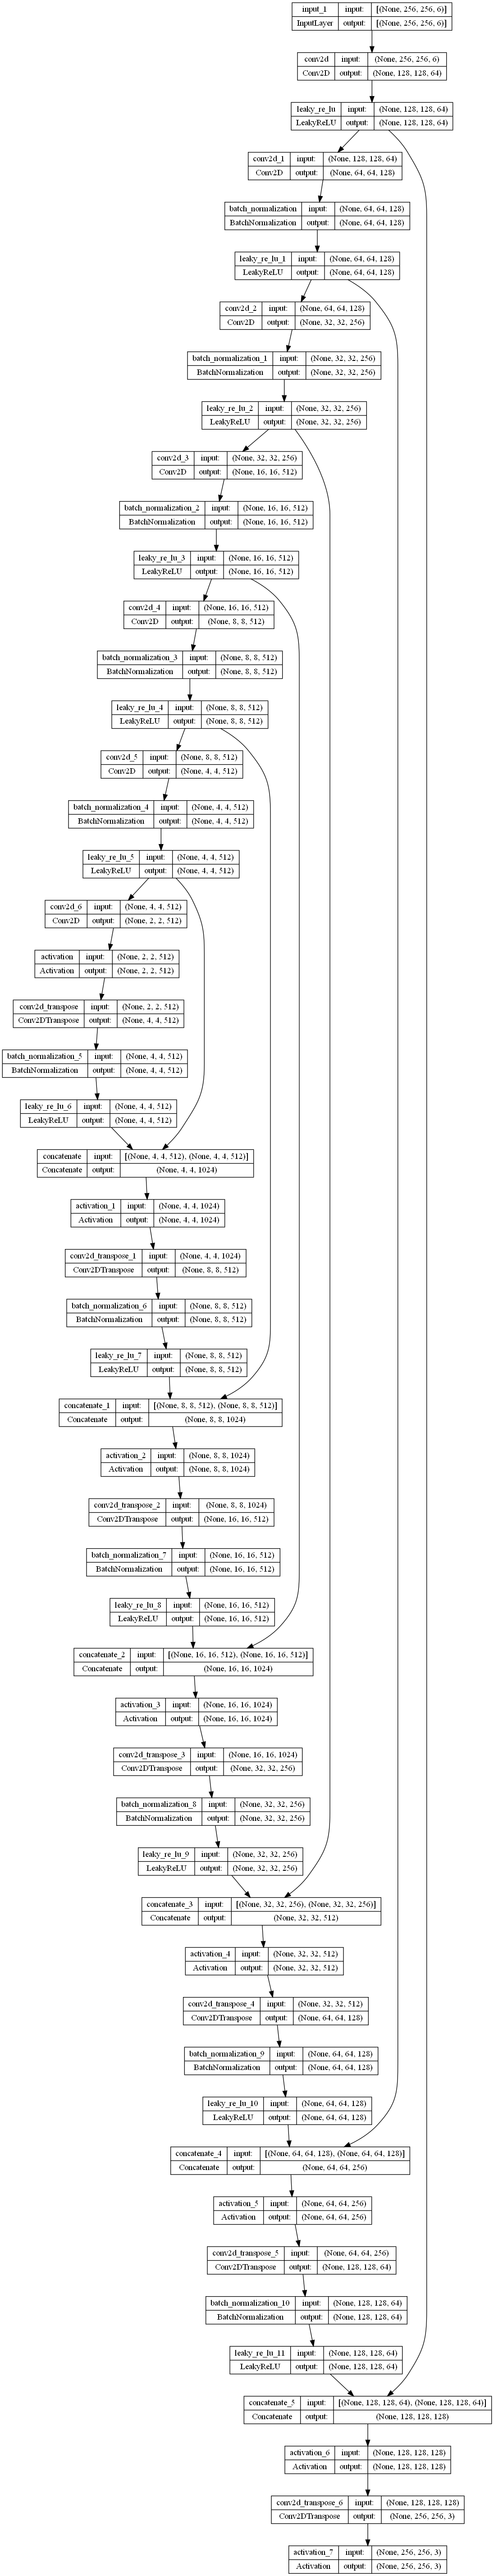

In [14]:
image_shape = (256, 256, 6)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True,show_layer_names=True)

In [15]:
generator = define_generator()
generator.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['mae']
)


In [16]:
import os
import tensorflow as tf

IMG_SIZE = (256, 256)  # Adjust as needed

def build_dataset(base_dir, batch_size=4):
    image_dir = os.path.join(base_dir, "image")
    cloth_dir = os.path.join(base_dir, "cloth")
    agnostic_dir = os.path.join(base_dir, "agnostic")

    person_paths = []
    cloth_paths = []
    agnostic_paths = []

    all_ids = set(f[:-4] for f in os.listdir(image_dir) if f.endswith(".jpg"))

    for img_id in sorted(all_ids):
        person = os.path.join(image_dir, img_id + ".jpg")
        cloth = os.path.join(cloth_dir, img_id + ".jpg")
        agnostic = os.path.join(agnostic_dir, img_id + ".jpg")

        if os.path.exists(person) and os.path.exists(cloth) and os.path.exists(agnostic):
            person_paths.append(person)
            cloth_paths.append(cloth)
            agnostic_paths.append(agnostic)

    if len(person_paths) == 0:
        raise ValueError("No valid image triplets found.")

    print(f"✅ Found {len(person_paths)} valid samples")

    # Build tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((cloth_paths, agnostic_paths, person_paths))

    def process(cloth_path, agnostic_path, person_path):
        def load_and_preprocess(path):
            image = tf.io.read_file(path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, IMG_SIZE)
            image = tf.cast(image, tf.float32) / 255.0
            return image

        cloth = load_and_preprocess(cloth_path)
        agnostic = load_and_preprocess(agnostic_path)
        person = load_and_preprocess(person_path)
        input_tensor = tf.concat([cloth, agnostic], axis=-1)
        return input_tensor, person

    dataset = dataset.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(300).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [17]:
import os
base_dir = r"C:\Users\abdul\PycharmProjects\DL_projects\AI_Powered_Clothing_Try_On\data\train"
subdirs = ['image', 'cloth', 'agnostic']

for sub in subdirs:
    folder = os.path.join(base_dir, sub)
    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    print(f"{sub}: {len(files)} images")


image: 11647 images
cloth: 11647 images
agnostic: 11647 images


In [18]:
for sub in subdirs:
    folder = os.path.join(base_dir, sub)
    files = sorted([f for f in os.listdir(folder) if f.endswith(".jpg")])
    print(f"\n{sub} sample files:")
    for f in files[:5]:
        print(" ", f)


image sample files:
  00000_00.jpg
  00001_00.jpg
  00002_00.jpg
  00003_00.jpg
  00005_00.jpg

cloth sample files:
  00000_00.jpg
  00001_00.jpg
  00002_00.jpg
  00003_00.jpg
  00005_00.jpg

agnostic sample files:
  00000_00.jpg
  00001_00.jpg
  00002_00.jpg
  00003_00.jpg
  00005_00.jpg


In [19]:
import os
import tensorflow as tf

# Image loader
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])  # VITON standard size
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Dataset builder
def build_dataset(root_dir, batch_size=8):
    image_dir = os.path.join(root_dir, 'image')
    cloth_dir = os.path.join(root_dir, 'cloth')
    agnostic_dir = os.path.join(root_dir, 'agnostic')

    # Use only image IDs that exist in all three folders
    image_ids = set(os.path.splitext(f)[0] for f in os.listdir(image_dir))
    cloth_ids = set(os.path.splitext(f)[0] for f in os.listdir(cloth_dir))
    agnostic_ids = set(os.path.splitext(f)[0] for f in os.listdir(agnostic_dir))

    # Keep only IDs that are common to all
    valid_ids = list(image_ids & cloth_ids & agnostic_ids)

    if len(valid_ids) == 0:
        raise ValueError("No valid image triplets found. Please check the folders.")

    print(f"✅ Found {len(valid_ids)} valid triplets")

    person_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in valid_ids]
    cloth_paths = [os.path.join(cloth_dir, f"{img_id}.jpg") for img_id in valid_ids]
    agnostic_paths = [os.path.join(agnostic_dir, f"{img_id}.jpg") for img_id in valid_ids]

    dataset = tf.data.Dataset.from_tensor_slices((cloth_paths, agnostic_paths, person_paths))

    def process_triplet(cloth_path, agnostic_path, person_path):
        cloth = load_and_preprocess_image(cloth_path)
        agnostic = load_and_preprocess_image(agnostic_path)
        person = load_and_preprocess_image(person_path)
        input_tensor = tf.concat([cloth, agnostic], axis=-1)
        return input_tensor, person

    dataset = dataset.map(process_triplet, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=200).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [20]:
DIR = r"C:\Users\abdul\PycharmProjects\DL_projects\AI_Powered_Clothing_Try_On\data\train"
train_dataset = build_dataset(DIR, batch_size=8)


✅ Found 11647 valid triplets


In [ ]:
generator = define_generator()
generator.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['mae']
)
history = generator.fit(train_dataset, epochs=20)


Epoch 1/20
1456/1456 [==============================] - 175s 114ms/step - loss: 0.0691 - mae: 0.0691
Epoch 2/20
1456/1456 [==============================] - 170s 116ms/step - loss: 0.0517 - mae: 0.0517
Epoch 3/20
1456/1456 [==============================] - 172s 118ms/step - loss: 0.0472 - mae: 0.0472
Epoch 4/20
1456/1456 [==============================] - 173s 119ms/step - loss: 0.0444 - mae: 0.0444
Epoch 5/20
1456/1456 [==============================] - 174s 119ms/step - loss: 0.0422 - mae: 0.0422
Epoch 6/20
1456/1456 [==============================] - 181s 124ms/step - loss: 0.0402 - mae: 0.0402
Epoch 7/20
1456/1456 [==============================] - 185s 127ms/step - loss: 0.0386 - mae: 0.0386
Epoch 8/20
1456/1456 [==============================] - 185s 127ms/step - loss: 0.0371 - mae: 0.0371
Epoch 9/20
1456/1456 [==============================] - 184s 126ms/step - loss: 0.0356 - mae: 0.0356
Epoch 10/20
1456/1456 [==============================] - 183s 126ms/step - loss: 0.0341 - m

In [25]:
generator.save('viton_generator_model.h5')


In [44]:
for inputs, targets in train_dataset.take(1):
    print("Inputs shape:", inputs.shape)   # (batch_size, height, width, channels)
    print("Targets shape:", targets.shape)

    input_tensor = inputs[0]               # Get the first input in the batch
    input_array = input_tensor.numpy()     # Convert to NumPy


Inputs shape: (8, 256, 256, 6)
Targets shape: (8, 256, 256, 3)


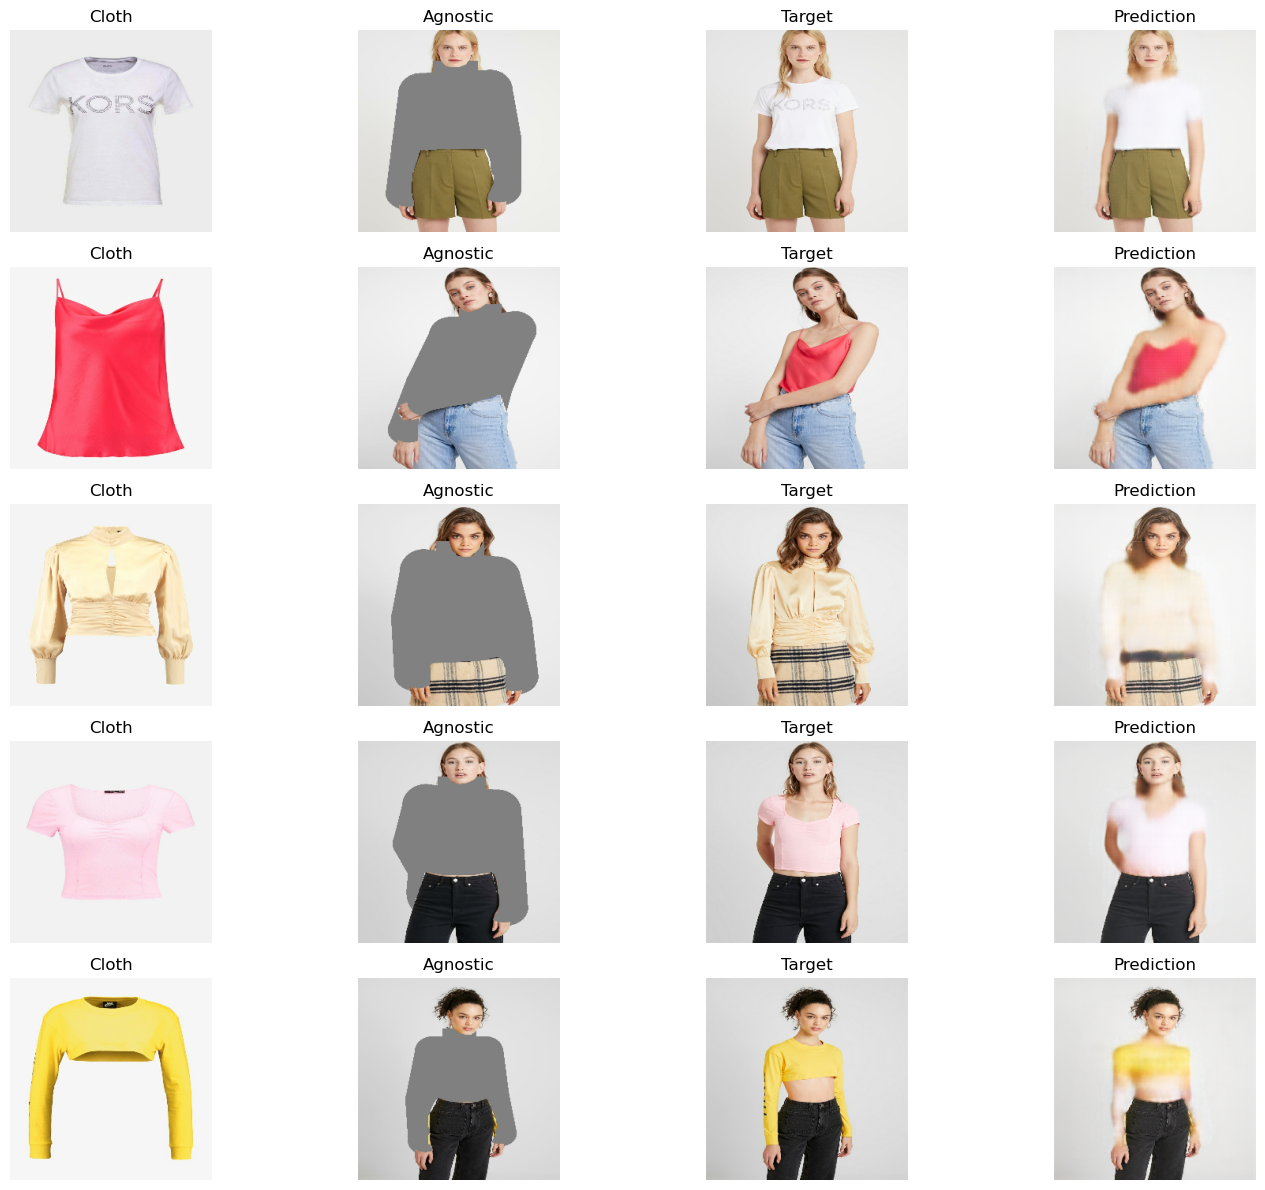

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fetch a batch of samples
for inputs, targets in train_dataset.take(1):
    preds = generator(inputs, training=False)
    break

# Normalize function
def normalize(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

# Plot 5 samples
plt.figure(figsize=(15, 12))

for i in range(5):
    input_tensor = inputs[i].numpy()
    target_tensor = targets[i].numpy()
    pred_tensor = preds[i].numpy()

    cloth_img = normalize(input_tensor[:, :, :3])
    agnostic_img = normalize(input_tensor[:, :, 3:])
    target_img = normalize(target_tensor)
    pred_img = normalize(pred_tensor)

    # Cloth
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(cloth_img)
    plt.title("Cloth")
    plt.axis("off")

    # Agnostic
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(agnostic_img)
    plt.title("Agnostic")
    plt.axis("off")

    # Target
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(target_img)
    plt.title("Target")
    plt.axis("off")

    # Prediction
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(pred_img)
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [50]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Set path to save predictions
SAVE_DIR = 'predicted_outputs'
os.makedirs(SAVE_DIR, exist_ok=True)

# Loop through dataset and save predicted images
def save_predictions(model, dataset, num_samples=5):
    for i, (inputs, targets) in enumerate(dataset.take(num_samples)):
        predictions = model.predict(tf.expand_dims(inputs, axis=0))  # Add batch dim
        
        # Remove batch dimension and convert to image format
        pred_img = tf.squeeze(predictions, axis=0)
        target_img = tf.squeeze(targets, axis=0)
        input_img = tf.squeeze(inputs, axis=0)

        # Convert to numpy and rescale to [0,255] for saving
        def convert_to_img(img_tensor):
            img = tf.clip_by_value(img_tensor, 0.0, 1.0)
            img = (img.numpy() * 255).astype('uint8')
            return img

        pred = convert_to_img(pred_img)
        target = convert_to_img(target_img)
        inp = convert_to_img(input_img[..., :3])  # Visualize cloth only

        # Save side-by-side comparison
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(inp)
        axs[0].set_title("Input (Cloth)")
        axs[1].imshow(pred)
        axs[1].set_title("Predicted Try-On")
        axs[2].imshow(target)
        axs[2].set_title("Ground Truth")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f'tryon_{i+1}.png'))
        plt.close()
    
    print(f"✅ Saved {num_samples} predicted images to {SAVE_DIR}/")

# Example usage:
# save_predictions(model=generator, dataset=train_dataset, num_samples=5)


In [51]:
save_predictions(model=generator, dataset=train_dataset, num_samples=5)  # Save 5 predicted images

InvalidArgumentError: Graph execution error:

Detected at node 'model_2/conv2d_14/Conv2D' defined at (most recent call last):
    File "c:\Users\abdul\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\abdul\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\abdul\AppData\Local\Temp\ipykernel_14188\3673687735.py", line 1, in <module>
      save_predictions(model=generator, dataset=train_dataset, num_samples=5)  # Save 5 predicted images
    File "C:\Users\abdul\AppData\Local\Temp\ipykernel_14188\1078564764.py", line 12, in save_predictions
      predictions = model.predict(tf.expand_dims(inputs, axis=0))  # Add batch dim
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\abdul\anaconda3\envs\py310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_2/conv2d_14/Conv2D'
input must be 4-dimensional[1,8,256,256,6]
	 [[{{node model_2/conv2d_14/Conv2D}}]] [Op:__inference_predict_function_126709]